<a href="https://colab.research.google.com/github/kojaxz/comp215/blob/main/TFT%20Project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

The goal of this project was to use the Riot Games API and make a social network map of the online multiplayer game TFT.  Using this map, I would be able to find things such as the clustering coefficent of a certain player, or the average shortest path lenghth between two players.  The project was originally going to compare the average shortest path length between two players at each rank, seeing how the average would change based on that factor.  Unfortunately due to limitations of the API itself this was not possible.

In [38]:
from pprint import pprint
import json, requests
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt
import time

Started with some test funtions.  These were originally only supposed to be used when I was testing how the API worked, and would be deleted afterwords.  It turns out that they were actually needed because the riot api is super restrictive with its rate limit its easier to get the puuid seperately, then make the player class with that as the input.

In [3]:
API_KEY = 'RGAPI-278b5904-5f46-4d5f-8285-da47e0dade85'  #riot api keys expire each day and need to be renewed

def get_puuid(summoner, tagline):
  '''
  Gets the puuid of a league of legends account

  Inputs:
    username and tagline (str)

  Outputs: PUUID (str)
  '''
  PUUID = f'https://americas.api.riotgames.com/riot/account/v1/accounts/by-riot-id/{summoner}/{tagline}?api_key={API_KEY}'
  response = requests.request("GET", PUUID, headers={}, data={})
  data = json.loads(response.text)
  return data['puuid']


my_puuid = get_puuid('koja', 'neon')

The above function takes a summoner name and tagline, and returns their puuid.  the puuid is required for getting info about the player account, and every account is reffered to my their puuid in the API data.

The below function gets the match data of an account and returns a list of match IDs

In [4]:
def get_tft_matches(puuid):
  '''
  returns a list of recent tft match ids

  Inputs: a players puuid (str)

  Outputs: list of match ids
  '''
  match_list = f'https://americas.api.riotgames.com/tft/match/v1/matches/by-puuid/{puuid}/ids?start=0&count=20&api_key={API_KEY}'
  response = requests.request("GET", match_list, headers={}, data={})
  data = json.loads(response.text)
  return data

gamelist = get_tft_matches(my_puuid)
pprint(get_tft_matches(my_puuid))

['NA1_5129157027',
 'NA1_5126380527',
 'NA1_5126355730',
 'NA1_5106749317',
 'NA1_4965365991',
 'NA1_4895476429',
 'NA1_4852148449',
 'NA1_4846270074',
 'NA1_4846235330',
 'NA1_4844117054',
 'NA1_4844070393',
 'NA1_4839170344',
 'NA1_4839125822',
 'NA1_4838484708',
 'NA1_4837140162',
 'NA1_4837086736',
 'NA1_4836964162',
 'NA1_4836704754',
 'NA1_4703660136']


The first of the next two functions gets match data when given the match ID of a game.  The second finds a player name based on their puuid.

In [5]:
def get_match_data(match_id):
  match_data = f'https://americas.api.riotgames.com/tft/match/v1/matches/{match_id}?api_key={API_KEY}'
  response = requests.request("GET", match_data, headers={}, data={})
  data = json.loads(response.text)
  return data['metadata']['participants']

def find_player_name(puuid1):
  match_data = f'https://americas.api.riotgames.com/riot/account/v1/accounts/by-puuid/{puuid1}?api_key={API_KEY}'
  response = requests.request("GET", match_data, headers={}, data={})
  data = json.loads(response.text)
  return data

This code below loops through a list of all my games, and adds them all to a dictionary where the key value pairs are the puuids of players I have played with, and the values are the amount of times I have played with them.

In [6]:
times_played = {}

for game in gamelist:
  game_data = get_match_data(game)
  for player in game_data:
    if player == my_puuid:
      continue
    if player not in times_played:
      times_played [player] = 1
    else:
      times_played [player] += 1

Then graphs the dictionary that was made above.  It has a node at the center, which in this case is me, then draws edges between that center node, and a node representing each player I have been in a game with.  The weight of each line is how many times we have played together.  The nodes closest to the center nodes are ones that I was in a game with most often.  and the ones that are further away were all only in one game, and they are staggered for the sake of visual clarity.

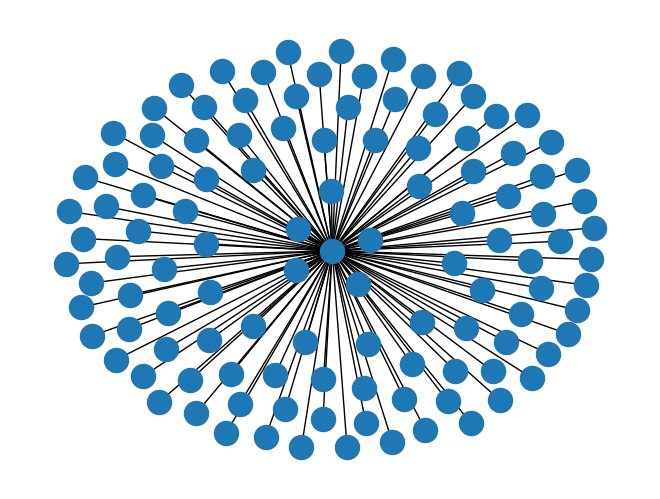

In [7]:
g = nx.Graph()
center_node = my_puuid
g.add_node(center_node)
for node, weight in times_played.items():
  g.add_edge(center_node, node, weight = weight)
# pprint(times_played)
nx.draw(g)

At this point the Riot API became almost impossible to work with.  The API has a rate limit of 20 requests every second, and 100 requests every two minutes.  My original plan was to repeat the above step for every player in my graph, then do the same for every player in their graph, and then add them all to the same graph.  This would create an interconnected graph of players and could be used to find a bunch of interesting information about the social network of TFT.  For example, average shortest path length or clustering coefficient would be interesting to see.

The code block below first contains two classes.  One is a Match class, this is created with a matchID, and has a method to get match data.  The second class is the player class.  The intention was to use a player's username and tagline to create the object, and then find thier puuid from within, as thats a lot simpler to use.  Due to the AIPs rate limit, I wanted to avoid using API calls as much as possible.  When you get the match info of a specific match, the players in that match are identified my their puuid, so finding the name and tagline of each player in a match would take one api request per player.  This would simply not be possible with the rate limit in place, so I decided to just use puuid instead.  

In [16]:
class Match:
  def __init__(self, matchID):
    '''
    class representing a match
    '''
    self.matchID = matchID

  def get_match_data(self):
    '''
    gets the match data for the match object
    '''
    match_data = f'https://americas.api.riotgames.com/tft/match/v1/matches/{self.matchID}?api_key={API_KEY}'
    response = requests.request("GET", match_data, headers={}, data={})
    data = json.loads(response.text)
    return data['metadata']['participants']

class Player:

  def __init__(self, puuid):
    '''
    class representing a player
    '''
    self.puuid = puuid

  def __eq__(self, other):
    '''
    defines what will be used to compare two player objects
    '''
    return self.puuid == other.puuid

  def __hash__(self):
    '''
    returns an integer that represents the object which is required if you want to use the object in a dictionary
    '''
    return hash(self.puuid)

  def get_puuid(self):
    '''
    gets the puuid of the player obj
    '''
    return self.puuid

  def find_player_name(self):
    '''
    finds the player name using the puuid ***this makes an api request every time its used, and it makes it really easy to hit the rate limit***
    '''
    match_data = f'https://americas.api.riotgames.com/riot/account/v1/accounts/by-puuid/{self.puuid}?api_key={API_KEY}'
    response = requests.request("GET", match_data, headers={}, data={})
    data = json.loads(response.text)
    return data['gameName'], data['tagLine']

  def get_tft_matches(self):
    '''
    returns a list of recent tft match ids

    Inputs: a players puuid (str)

    Outputs: list of match ids
    '''
    match_list = f'https://americas.api.riotgames.com/tft/match/v1/matches/by-puuid/{self.puuid}/ids?start=0&count=20&api_key={API_KEY}'
    response = requests.request("GET", match_list, headers={}, data={})
    data = json.loads(response.text)
    return data

def gamelist(puuid):
  '''
  takes the puuid of a player and returns a dictionary of who they played with and how many times
  '''
  gameslist = get_tft_matches(puuid)
  times_played = {}
  print(gameslist)
  for game in gameslist:
    game_data = get_match_data(game)
    for player in game_data:
      playerobj = Player(player)
      if playerobj.get_puuid() == puuid:
        continue
      if playerobj not in times_played:
        times_played [playerobj] = 1
      else:
        times_played [playerobj] += 1
  return times_played

#get specifically my player object, and mathias's player object, as i want to esure that both of us are on the graph
koja = Player('k-dTIMqwC13kiqs4xHrH6qooH39-TBMoIkK134xIQN-CCTjwhTD1LP1mFyMFGGdcKyjIrxe7P3DNjA')
mjs = Player('vAMuU90-_M1MPHms59JOE47mABpUgNsrOLB_wtrOJMCUdKY8C-VEIDbH8pUCR1WTzfrQVVH8kBTgxg')

#create the graph up here so I can add to it in the below code without resetting it
g = nx.Graph()

def graph(center, times_played):
  '''
  takes an input of a player and a dictionary with the people the center player has played with as the keys, and the values being how many times.
  '''
  g.add_node(center)
  for node, weight in times_played.items():
    g.add_edge(center, node, weight = weight)


def add_other(graph, playerobj):
  '''
  takes an already existing player graph and another player object, and adds their info to the original graph
  '''

  games_played = gamelist(playerobj.get_puuid())

  if not g.has_node(playerobj):
    g.add_node(playerobj)

  for player, weight in games_played.items():
    g.add_edge(playerobj, player, weight = weight)

#runs the graph function with me as the center node
graph(koja, gamelist(koja.get_puuid()))
#adds 12 of the nodes on my graph to a list
add_nodes = list(g.nodes)[:12]
#graphs those players and their games played
for node in add_nodes:
  time.sleep(120)
  add_other(g, node)

#adds mathias to the graph
add_other(g, mjs)


['NA1_5129157027', 'NA1_5126380527', 'NA1_5126355730', 'NA1_5106749317', 'NA1_4965365991', 'NA1_4895476429', 'NA1_4852148449', 'NA1_4846270074', 'NA1_4846235330', 'NA1_4844117054', 'NA1_4844070393', 'NA1_4839170344', 'NA1_4839125822', 'NA1_4838484708', 'NA1_4837140162', 'NA1_4837086736', 'NA1_4836964162', 'NA1_4836704754', 'NA1_4703660136']
['NA1_5129157027', 'NA1_5126380527', 'NA1_5126355730', 'NA1_5106749317', 'NA1_4965365991', 'NA1_4895476429', 'NA1_4852148449', 'NA1_4846270074', 'NA1_4846235330', 'NA1_4844117054', 'NA1_4844070393', 'NA1_4839170344', 'NA1_4839125822', 'NA1_4838484708', 'NA1_4837140162', 'NA1_4837086736', 'NA1_4836964162', 'NA1_4836704754', 'NA1_4703660136']
['NA1_5205877979', 'NA1_5198054477', 'NA1_5189386454', 'NA1_5187663916', 'NA1_5181668125', 'NA1_5181659743', 'NA1_5173930845', 'NA1_5173923289', 'NA1_5173908940', 'NA1_5173016932', 'NA1_5171150405', 'NA1_5171110620', 'NA1_5169911668', 'NA1_5169876627', 'NA1_5164760603', 'NA1_5164749537', 'NA1_5164730082', 'NA1_51

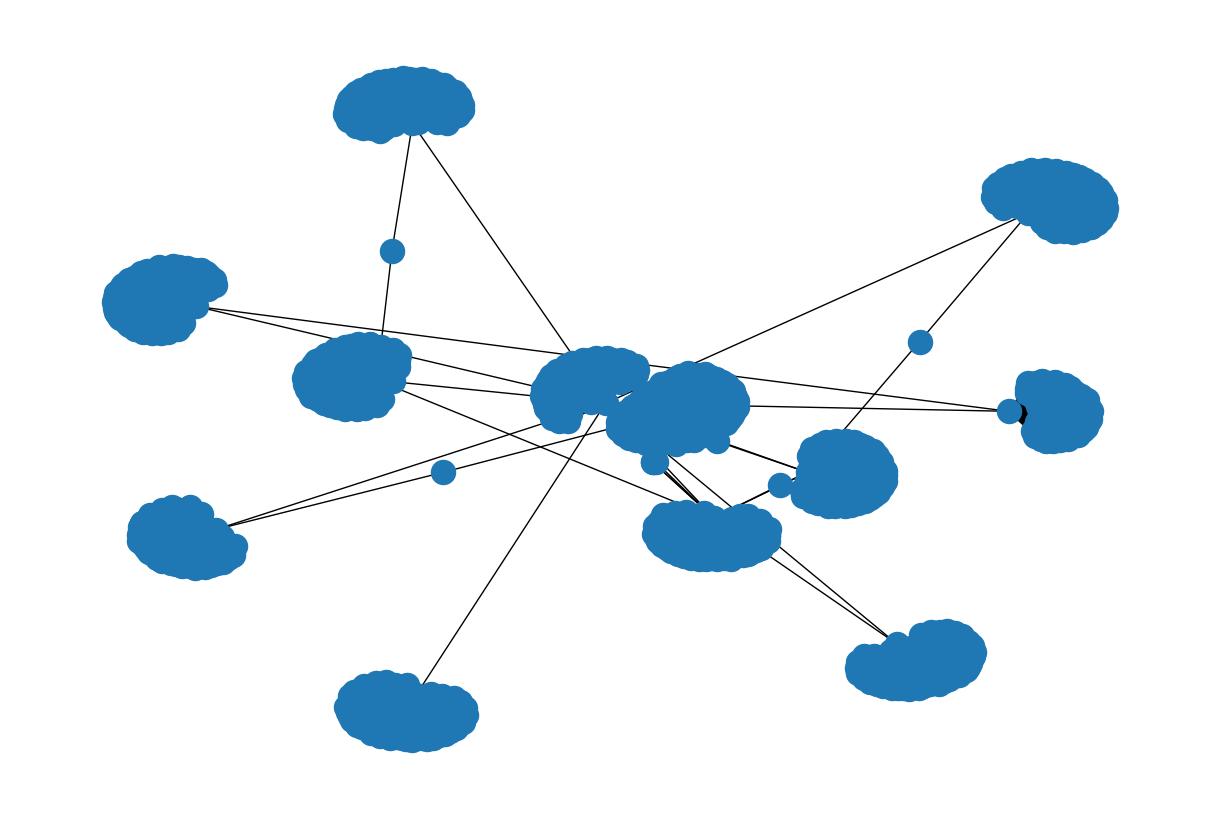

In [25]:
#draw
plt.figure(figsize=(12,8))
nx.draw(g)

In [39]:
#prints the average clustering, average shortest path length, amount of edges, and amount of nodes.
print(nx.average_clustering(g))
print(nx.average_shortest_path_length(g))
print(len(g.edges))
print(len(g))

0.0033328629230418164
3.6460359760159893
1512
1501


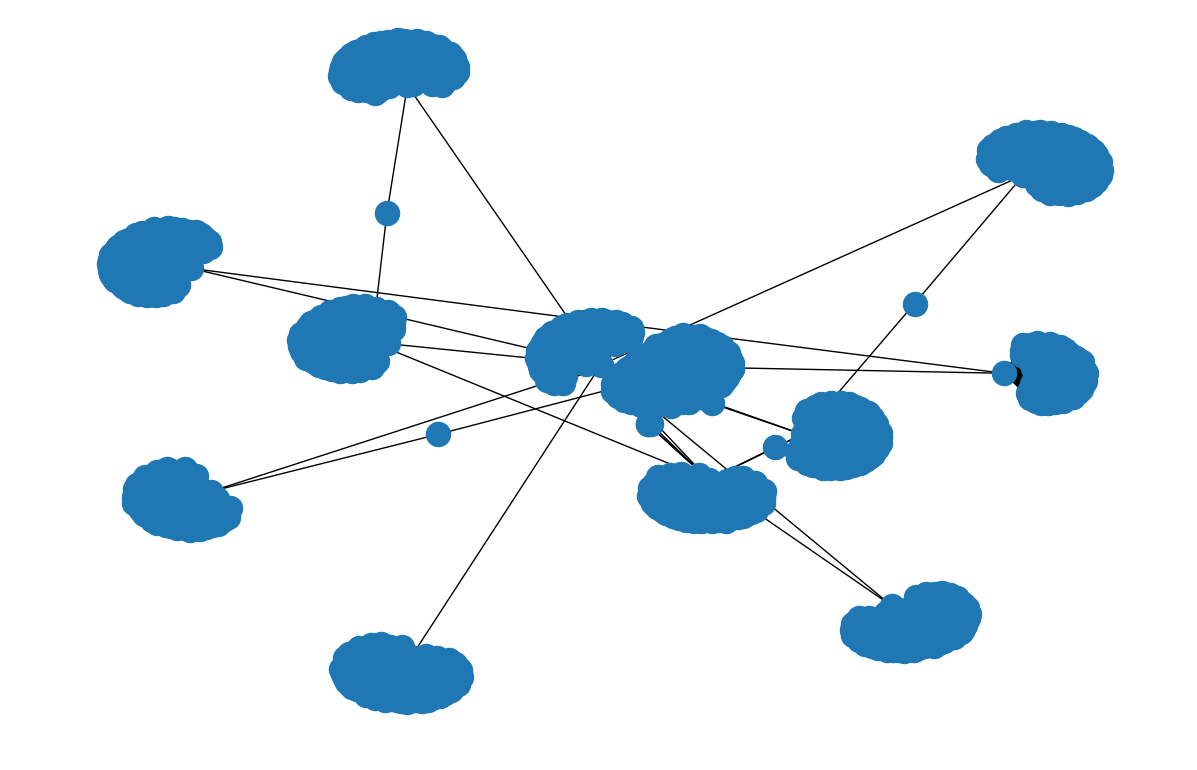

Some aspects of this code were debugged with assistance from ChatGPT